In [1]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

### 데이터 로드 / 확인

In [2]:
cifar10 = tf.keras.datasets.cifar10 
(train_x, _), (test_x, _) = cifar10.load_data()

In [3]:
train_x.max()

255

In [4]:
train_x.min()

0

In [5]:
train_x = (train_x - 127.5) / 127.5                                      # 이걸 왜하는 거지

In [6]:
type(train_x)

numpy.ndarray

In [7]:
train_x.shape

(50000, 32, 32, 3)

In [8]:
train_x.size

153600000

In [9]:
len(train_x)

50000

In [10]:
train_x[0]

array([[[-0.5372549 , -0.51372549, -0.50588235],
        [-0.6627451 , -0.63921569, -0.64705882],
        [-0.60784314, -0.62352941, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215686, -0.01960784, -0.2       ],
        [ 0.16078431, -0.02745098, -0.19215686]],

       [[-0.8745098 , -0.84313725, -0.84313725],
        [-1.        , -1.        , -1.        ],
        [-0.85882353, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980392, -0.56862745],
        [-0.06666667, -0.34901961, -0.60784314],
        [-0.04313725, -0.31764706, -0.55294118]],

       [[-0.80392157, -0.81176471, -0.83529412],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.61568627, -0.78823529, -0.9372549 ],
        ...,
        [-0.0745098 , -0.34117647, -0.60784314],
        [-0.05882353, -0.34117647, -0.60784314],
        [-0.14509804, -0.42745098, -0.67058824]],

       ...,

       [[ 0.63137255,  0.33333333, -0.24705882],
        [ 0

In [11]:
train_x[0].shape

(32, 32, 3)

In [12]:
test_x.shape

(10000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


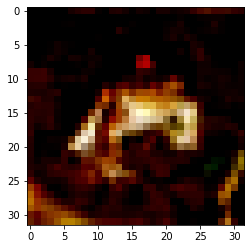

In [13]:
plt.imshow(train_x[0].reshape(32,32,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

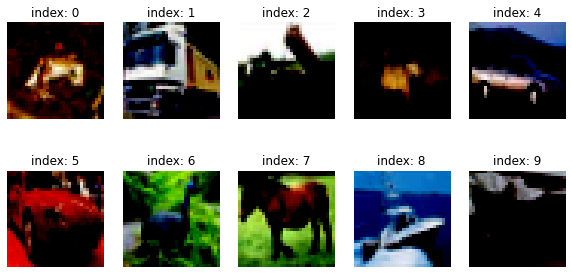

In [14]:
plt.figure(figsize=(10,5))                                    

for i in range(10):
    plt.subplot(2,5,i+1)                                            
    plt.imshow(train_x[i].reshape(32,32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 데이터 섞기, 배치 사이즈 설정 (파이프라인 작성)

In [15]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## DCGAN 생성자 구현

In [16]:
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))  # 여기 잘 이해가 안 간다
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [17]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [18]:
noise = tf.random.normal([1,100])

In [19]:
noise.shape

TensorShape([1, 100])

In [20]:
generated_image = generator(noise, training =False)
generated_image.shape

TensorShape([1, 32, 32, 3])

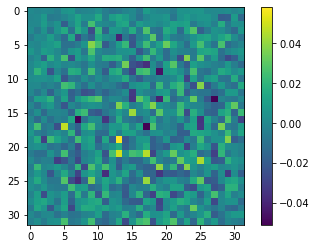

In [21]:
plt.imshow(generated_image[0, :, :, 0])   #[0, :, :, 0] 이게 뭐지?
plt.colorbar()
plt.show()                                                 # 왜 파랗게 나오는 거지?



## 판별자 구현하기

In [22]:
def make_discriminator_model():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [23]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [24]:
decision = discriminator(generated_image, training = False)
decision
       

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.001601]], dtype=float32)>

## 모델 학습 준비

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

### 생성자 손실함수

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 판별자 손실함수

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss                               # 이 둘을 더한다는 게 무슨 의미일까?
                                                                 

In [28]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy 

# real_accuracy와 fake_accuracy가  처음엔 1에 가깝게 나오다가 서서히 낮아져서 0.5에 가까워지는게 이상적이라고 노드에 설명돼 있는데
# 1. 일단 이걸 구현한 위 코드 두줄이 이해가 잘 안가고
# 2. 약간 인위적인 느낌이 드는데 이 찝찝함은 뭘까

### 최적화 함수

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)         # learning rate 값 바꿔가며 해볼 것             

## 생성자가 생성한 샘플을 확인하는 함수

In [30]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 하나의 미니배치당 진행할 train_step 함수

In [31]:

@tf.function
def train_step(images): 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:   # 왜 tape, disc 라는 단어를 쓴 걸까?
        generated_images = generator(noise, training=True) 

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # trainable_variables 요녀석이 어디서 튀나온거지
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy 

### 학습현황을 볼 수 있는 샘플을 생성하는 함수

In [39]:

    
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/mini_projects/_E-12_GAN/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### train_step() 함수의 리턴값을 매 epoch마다 시각화하는 함수

In [40]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_losss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    plt.savefig('{}/mini_projects/_E-12_GAN/training_history/train_history_{:04d}.png'.format(os.getenv('HOME'), epoch))
    plt.show()

### check point

In [41]:
checkpoint_dir = os.getenv('HOME') +'/mini_projects/_E-12_GAN/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

# 학습

In [42]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history,epoch)
        
            

In [43]:
save_every = 5
EPOCHS = 500

In [44]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

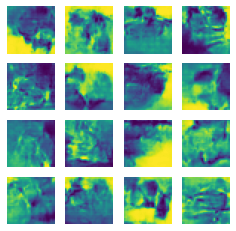

Time for training : 5693 sec


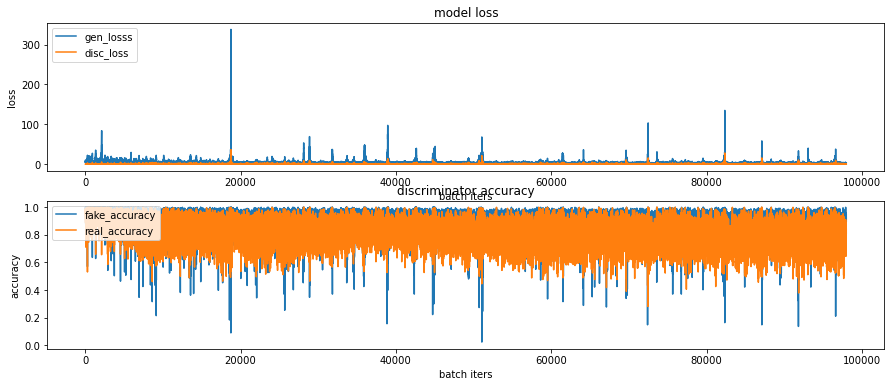

In [45]:
train(train_dataset, EPOCHS, save_every)

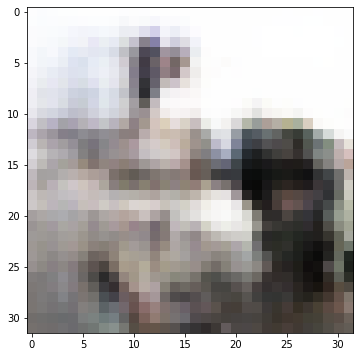

In [47]:
checkpoint_dir = os.getenv('HOME')+'/mini_projecs/_E-12_GAN/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다

### 학습과정 시각화하기

In [50]:
anim_file = os.getenv('HOME')+'/mini_projects/_E-12_GAN/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/mini_projects/_E-12_GAN/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/mini_projects/_E-12_GAN/cifar10_dcgan.gif

-rw-r--r-- 1 aiffel aiffel 4076721  2월 25 22:05 /home/aiffel/mini_projects/_E-12_GAN/cifar10_dcgan.gif


In [ ]:
이미지 생성 중간결과들을 컬러로 보게 하려면 어떻게 해야할까

In [ ]:
8 8 256

# 회고   
지난 2주 동안 LSTM, seq2seq, attention만 바라보면서 달렸더니   
토가 나올 거 같아 멈춰서니까 GAN이 보였다.         
뉴스요약봇 만드는 노드에 모든 에너지와 시간을 쏟고 싶었는데   
정작 프로젝트를 할때가 되어선 녹초가 돼서 뭘 제대로 하지도 못하고 제출하고   
여력을 GAN을 하나하나 뜯어보는 데 쓰게 되었다.   
GAN도 너무 흥미로워 나쁘진 않은데   
뭔가 리듬을 잘못 탄거 같아서 기분이 썩 좋지 않다   
이 프로젝트가 어줍잖은 패션만들기가 아니라 문장생성하는 GAN이었다면 좀 달랐을까   
확실히 관심이 가는 모델이면 세세한 부분까지 파고들어 진이 빠지는 게 즐겁기만 하다.   
그런데 너무 한쪽으로 치우친 느낌이 들기도 한다   
어차피 답은 정해져 있다.   
주식노드는 제끼고 폐렴 노드에 집중을 해야겠다.   
   
attention과 GAN을 보면서   
참 많은 생각이 들었다.   
attention이 자아성찰의 느낌이라면   
GAN은 무한경쟁의 느낌이다.   
둘 다 인간의 성장에 필수적인 양면성을 이룬다는 점에서   
뭔가 이 둘을 합쳐보고 싶다는 생각이 문득 들었다.   
잘은 모르겠는데   
메타 모델이라는 용어가 있나 싶다.   
모델이 모델을 학습시키고 평가하는 그림이랄까.   
얼핏보면 attention과 GAN이 융합될 수있는 점이 없어 보인다.   
과연 그럴까?

이번엔 복붙을 안하고 손으로 다 코딩을 해봤다.   

에러가 엄청났다.   

함수를 써놓고 리턴값을 빼먹는다거나   
output인데 out이라고만 적었다거나   
함수의 파라미터에 들어가는 변수와 그 변수가 다시 다른 함수의 파라미터로 들어가는 복잡하게 꼬인 코드들에서 이름 하나를 잘못썼다든가   
점 하나를 빼먹었다든가,   괄호를 빼먹었다든가   

In [ ]:
Adam(1e-3)  